# Introduction
This is an analysis of **mpg car** dataset with following features :
 * `mpg`: Continuous variable representing miles per gallon.
 * `cylinders`: Multi-valued discrete variable representing the number of cylinders in the car.
 * `displacement`: Continuous variable representing the displacement of the car's engine.
 * `horsepower`: Continuous variable representing the horsepower of the car's engine.
 * `weight`: Continuous variable representing the weight of the car.
 * `acceleration`: Continuous variable representing the acceleration of the car.
 * `model year`: Multi-valued discrete variable representing the model year of the car.
 * `origin`: Multi-valued discrete variable representing the origin of the car (1 for USA, 2 for Europe, 3 for Japan).
 * `car name`: String (usually ignored in regression analysis).
  
Objective of this analysis is to evaluate engines efficiency, in particular their miles per gallon.  
Then we will predict `mpg` with a Machine Learning and deploy this model using and API.

# Libraries

In [359]:
# handeling data and linear algebra
import pandas as pd
import numpy as np

# ignore warnings on notebook outputs
import warnings
warnings.filterwarnings('ignore') 

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error
import joblib

# Data Importation

In [314]:
data = pd.read_csv('auto-mpg.csv')
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


## Data Cleaning

### Missing Values

In [315]:
data.describe()

,mpg,cylinders,displacement,weight,acceleration,model year,origin
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,5140.000000,24.800000,82.000000,3.000000


This dataset regroup data from ~400 different cars from Asia, USA and Europe between 1970 and 1982

In [316]:
data.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

In [317]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


No visible missing values in this dataframe. But `horsepower` is in *object* format instead of float so let's look at it.

In [318]:
data['horsepower'].unique()

array(['130', '165', '150', '140', '198', '220', '215', '225', '190',
       '170', '160', '95', '97', '85', '88', '46', '87', '90', '113',
       '200', '210', '193', '?', '100', '105', '175', '153', '180', '110',
       '72', '86', '70', '76', '65', '69', '60', '80', '54', '208', '155',
       '112', '92', '145', '137', '158', '167', '94', '107', '230', '49',
       '75', '91', '122', '67', '83', '78', '52', '61', '93', '148',
       '129', '96', '71', '98', '115', '53', '81', '79', '120', '152',
       '102', '108', '68', '58', '149', '89', '63', '48', '66', '139',
       '103', '125', '133', '138', '135', '142', '77', '62', '132', '84',
       '64', '74', '116', '82'], dtype=object)

Missing values are replaced by '?'. Let's replace them by actual missing values :

In [319]:
data['horsepower'][data['horsepower'] == '?'] = np.nan
data['horsepower'] = pd.to_numeric(data['horsepower'])
data.isnull().sum()/len(data)*100 # percentage of missing values

mpg             0.000000
cylinders       0.000000
displacement    0.000000
horsepower      1.507538
weight          0.000000
acceleration    0.000000
model year      0.000000
origin          0.000000
car name        0.000000
dtype: float64

$1.5 \%$ of ```data['horsepower']``` are missing so a possibility would be to ignore them.  
Let's verify that Missing Values are MCAR first (Missing Completely at Random)

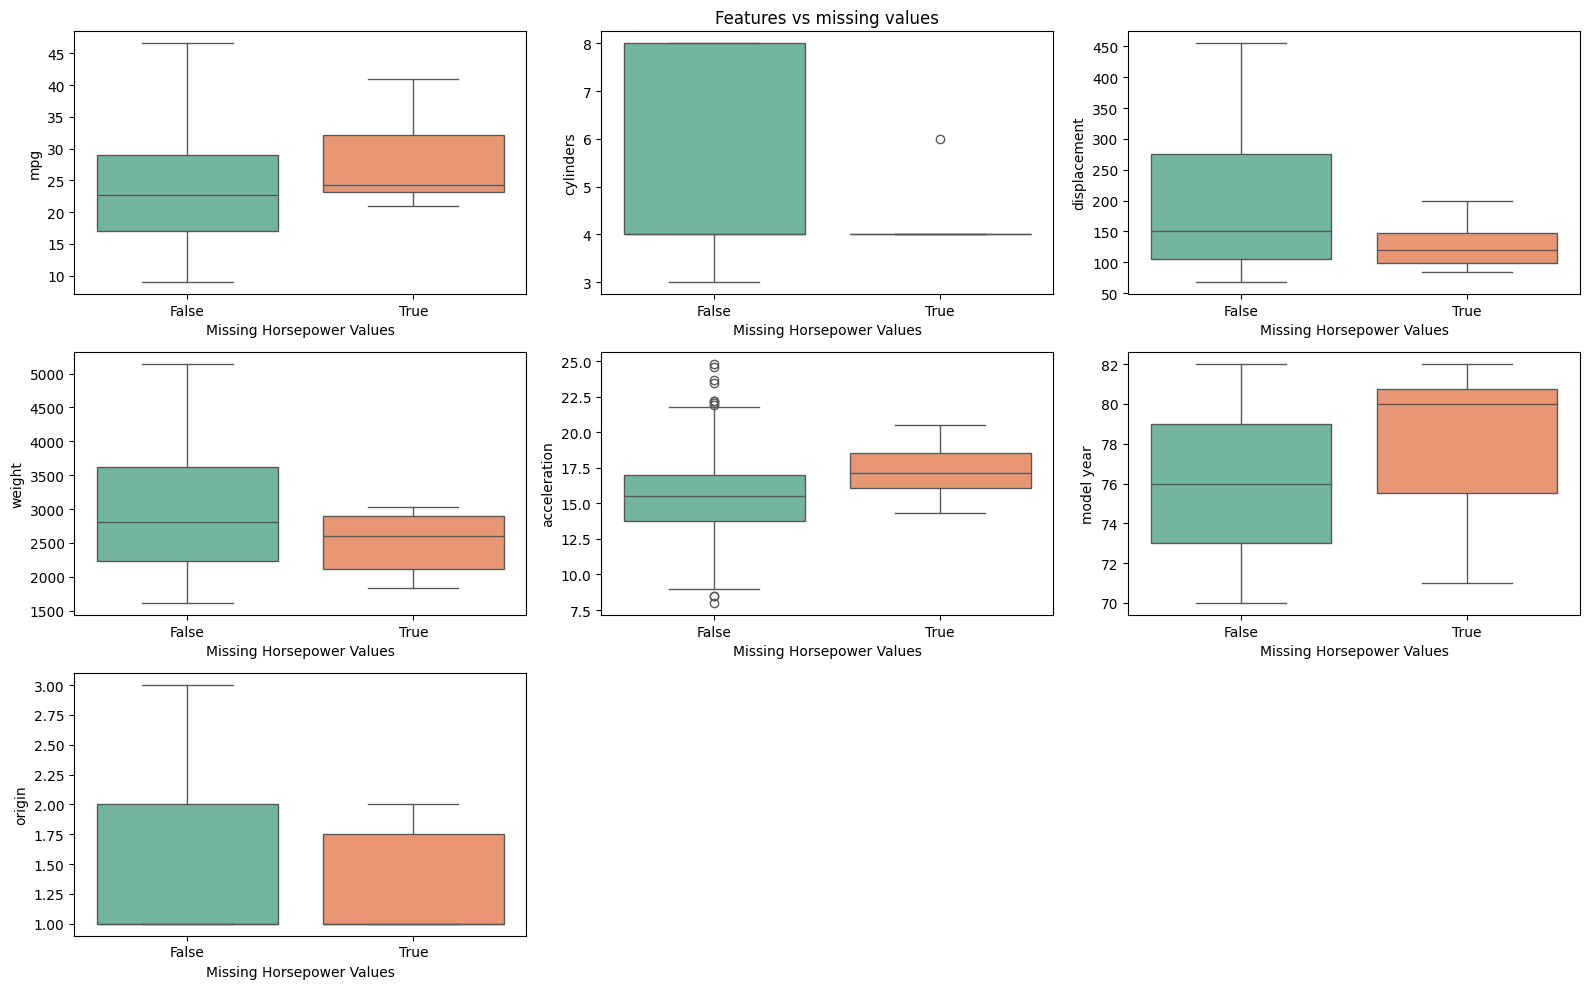

In [320]:
data['hp_missing'] = data['horsepower'].isna()

# boxplots for each features vs missing values
plt.figure(figsize=(16, 10))
plt.title('Features vs missing values')
plt.axis('off')
for i, column in enumerate(data.columns.drop(['car name', 'hp_missing', 'horsepower'])):
    plt.subplot(3, 3, i+1)
    ax = sns.boxplot(x='hp_missing', y=column, data=data, hue='hp_missing',
                 legend=False, palette='Set2')
    ax.set(xlabel="Missing Horsepower Values")

plt.tight_layout()
plt.show()

We can see that missing values are not correlated to actual values, global means between groups are similar.  
e.g : missing horsepower in data does not depend on car weight. So we will replace missing values by the mean of horsepower.

In [321]:
mean_hp = np.mean(data['horsepower'])
data['horsepower'][data['horsepower'].isna()] = mean_hp
data['horsepower'].isna().sum() # no more missing values

np.int64(0)

In [322]:
data = data.drop(['hp_missing'], axis=1)
data.head(1)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu


### Outliers

[]

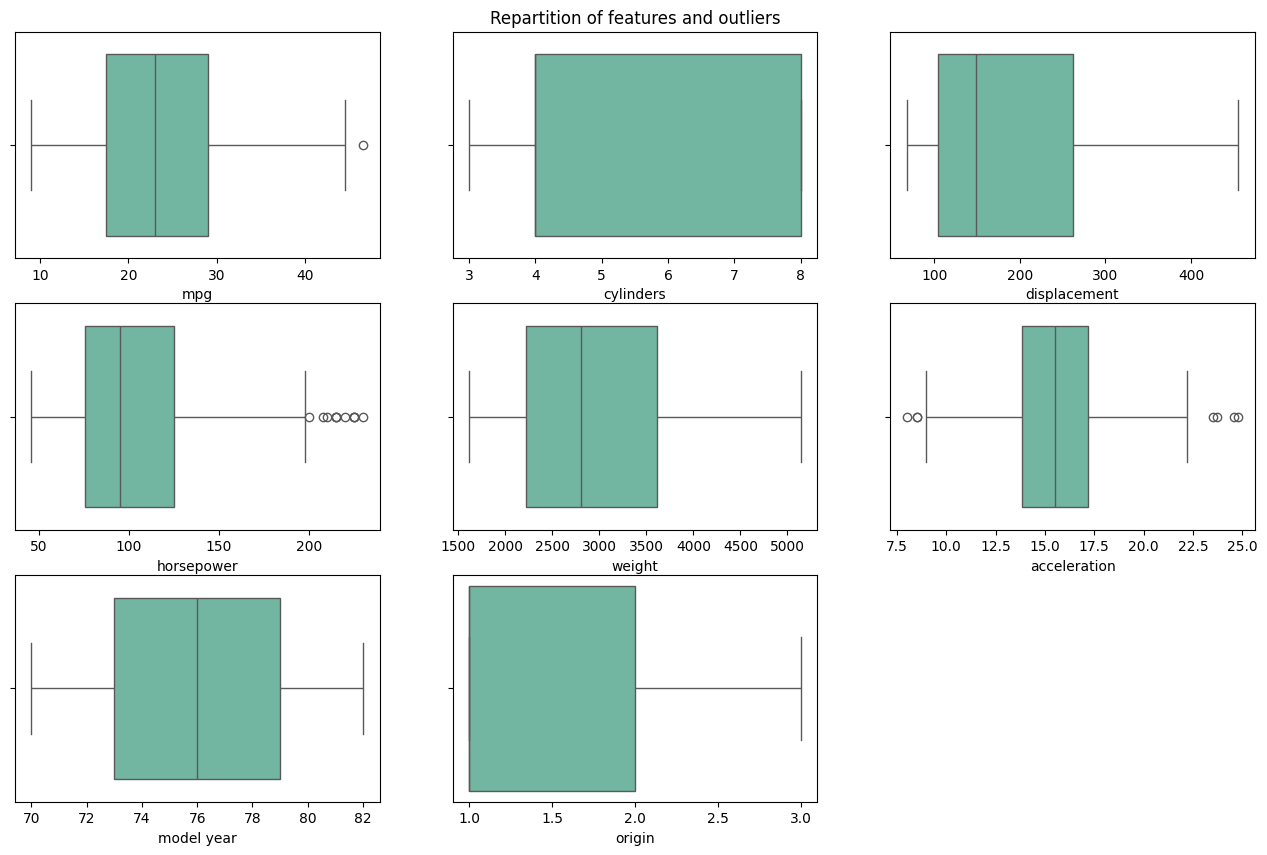

In [323]:
plt.figure(figsize=(16, 10))
plt.title("Repartition of features and outliers")
plt.axis('off')
for i, column in enumerate(data.columns.drop(['car name'])):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x=column, data=data,
                 legend=False, palette='Set2')
plt.plot()

Let's look at powerfull car to understand outliers :

In [324]:
powerfull_cars = data[data['horsepower'] > 200]
powerfull_cars.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
6,14.0,8,454.0,220.0,4354,9.0,70,1,chevrolet impala
7,14.0,8,440.0,215.0,4312,8.5,70,1,plymouth fury iii
8,14.0,8,455.0,225.0,4425,10.0,70,1,pontiac catalina
13,14.0,8,455.0,225.0,3086,10.0,70,1,buick estate wagon (sw)
25,10.0,8,360.0,215.0,4615,14.0,70,1,ford f250


In [325]:
powerfull_cars.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
count,10.000000,10.0,10.000000,10.000000,10.000000,10.000000,10.000000,10.0
mean,12.900000,8.0,420.600000,218.800000,4377.100000,10.750000,71.100000,1.0
std,1.852926,0.0,47.272731,7.299924,501.485006,1.798919,1.449138,0.0
min,10.000000,8.0,318.000000,208.000000,3086.000000,8.500000,70.000000,1.0
25%,11.250000,8.0,407.250000,215.000000,4322.500000,9.625000,70.000000,1.0
50%,13.500000,8.0,440.000000,217.500000,4403.500000,10.500000,70.000000,1.0
75%,14.000000,8.0,454.750000,225.000000,4628.500000,11.000000,72.750000,1.0
max,16.000000,8.0,455.000000,230.000000,4951.000000,14.000000,73.000000,1.0


We can see that it is not actually outliers but just old (from the 70's) American cars with V10 engine with absurdly powerfull engines.  

In [326]:
fast_cars = data[data['acceleration'] > 22.5]
fast_cars

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
59,23.0,4,97.0,54.0,2254,23.5,72,2,volkswagen type 3
299,27.2,4,141.0,71.0,3190,24.8,79,2,peugeot 504
326,43.4,4,90.0,48.0,2335,23.7,80,2,vw dasher (diesel)
394,44.0,4,97.0,52.0,2130,24.6,82,2,vw pickup


We can see that more recent cars (from the 80's) are quicker than older ones, which is logical.

In conclusion, there is no outlier, just some cars that have particular features, still coherent with laws of physics.

# Data Visualization

In order to evaluate categorical feature `origin`, we must first convert column to categorical.

In [327]:
data['origin'][data['origin'] == 1] = 'USA'
data['origin'][data['origin'] == 2] = 'Europe'
data['origin'][data['origin'] == 3] = 'Asia'
data['origin'] = data['origin'].astype('category')
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504,12.0,70,USA,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,USA,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,USA,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,USA,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,USA,ford torino


## Univariate Statistics

### Country of production

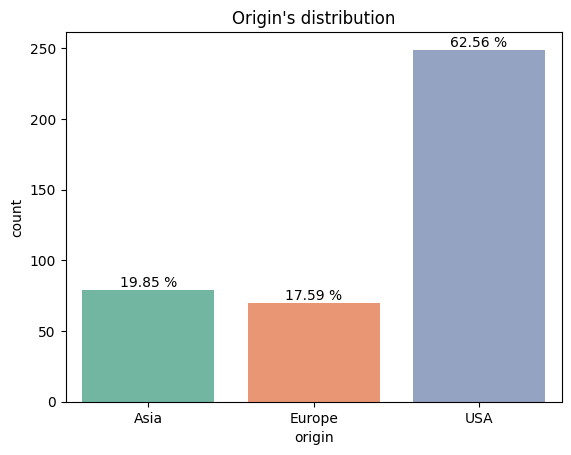

In [328]:
# calculate percentage
percentages = []
for origin in ['Asia', 'Europe', 'USA']:
    p = (data['origin'][data['origin'] == origin].count()) / data.count()
    percentages.append(p[0])

# create barplot
ax = sns.countplot(data=data, x='origin', palette='Set2')
# add percentages
for i, container in enumerate(ax.containers) :
    ax.bar_label(container, fmt=f'{percentages[i]*100:.2f} %')

plt.title('Origin\'s distribution')
plt.show()

Most of the analysed car are manufactured in the US.

### Numerical features

[]

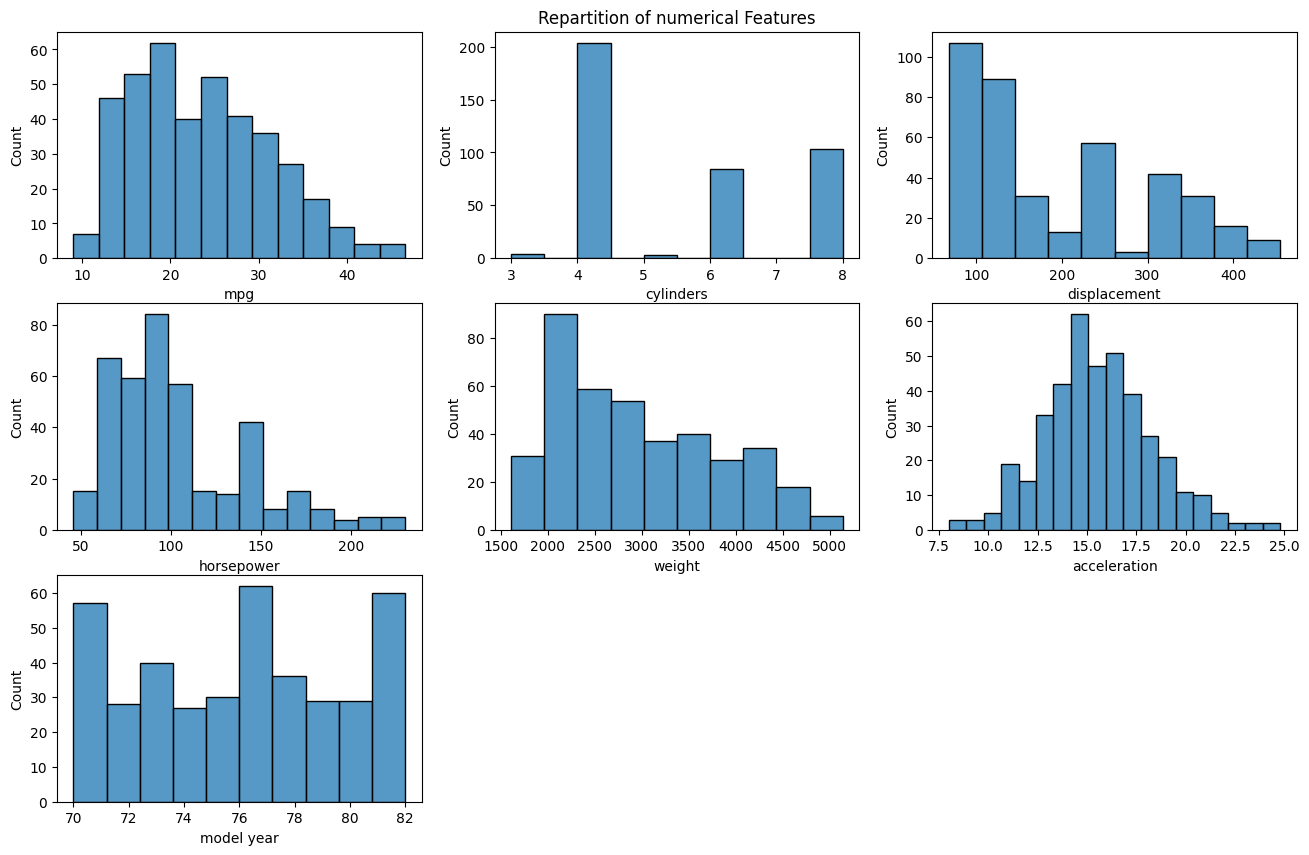

In [329]:
plt.figure(figsize=(16, 10))
plt.title("Repartition of numerical Features")
plt.axis('off')
for i, column in enumerate(data.select_dtypes(include=np.number)):
    plt.subplot(3, 3, i+1)
    sns.histplot(x=column, data=data,
                 legend=False, palette='Set2')
plt.plot()

We can see that :  
 * `model year` is spread following an **uniform distribution**. Which is good for our data quality (equal representation of each year of production)
 * most of the cars have 4 `cylinders`, some have 6 or 8 $\rightarrow$ coherent with reality.  
 
With these simple visualization, we can appretiate the quality of the dataset, which is representative of real life values.

## Multivariate Statistics

### Correlation Matrix

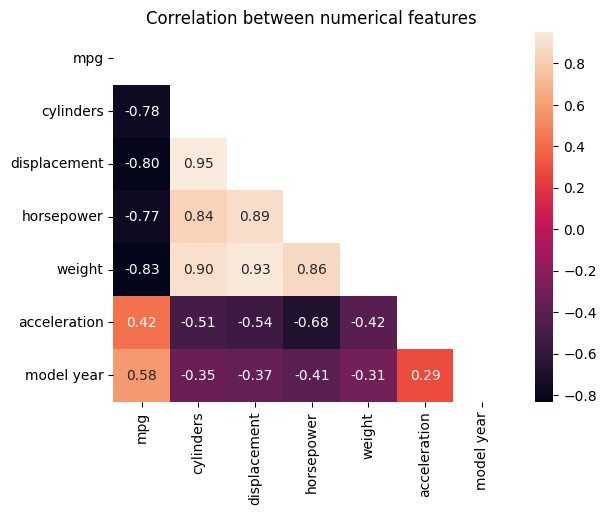

In [330]:
corr = data.select_dtypes(include=np.number).corr()
# for triangle display
mask = np.triu(corr)
sns.heatmap(corr, annot=True, mask=mask, fmt='.2f')
plt.title('Correlation between numerical features')
plt.show()

We can see that :
 * `weight` is highly correlated **(+)** with `cylinders` and `horsepower`, the more an engine is big (# of cylinders), the more heavy and powerfull it will be.
 * `mpg` is highly correlated **(-)** with `cylinders`, `horsepower` and `weight`, meaning that the more powerfull and heavy an engine is, the less full efficient it will be.
 * surprisingly, `acceleration` is **(-)** correlated with `horsepower`, meaning that with more horsepower, a car will be slower (due to its weight gain among other things)

As target feature `mpg` is highly correlated with each other features, this dataset is really well suited for a Machine Learning approach.

### MPG vs other features

[]

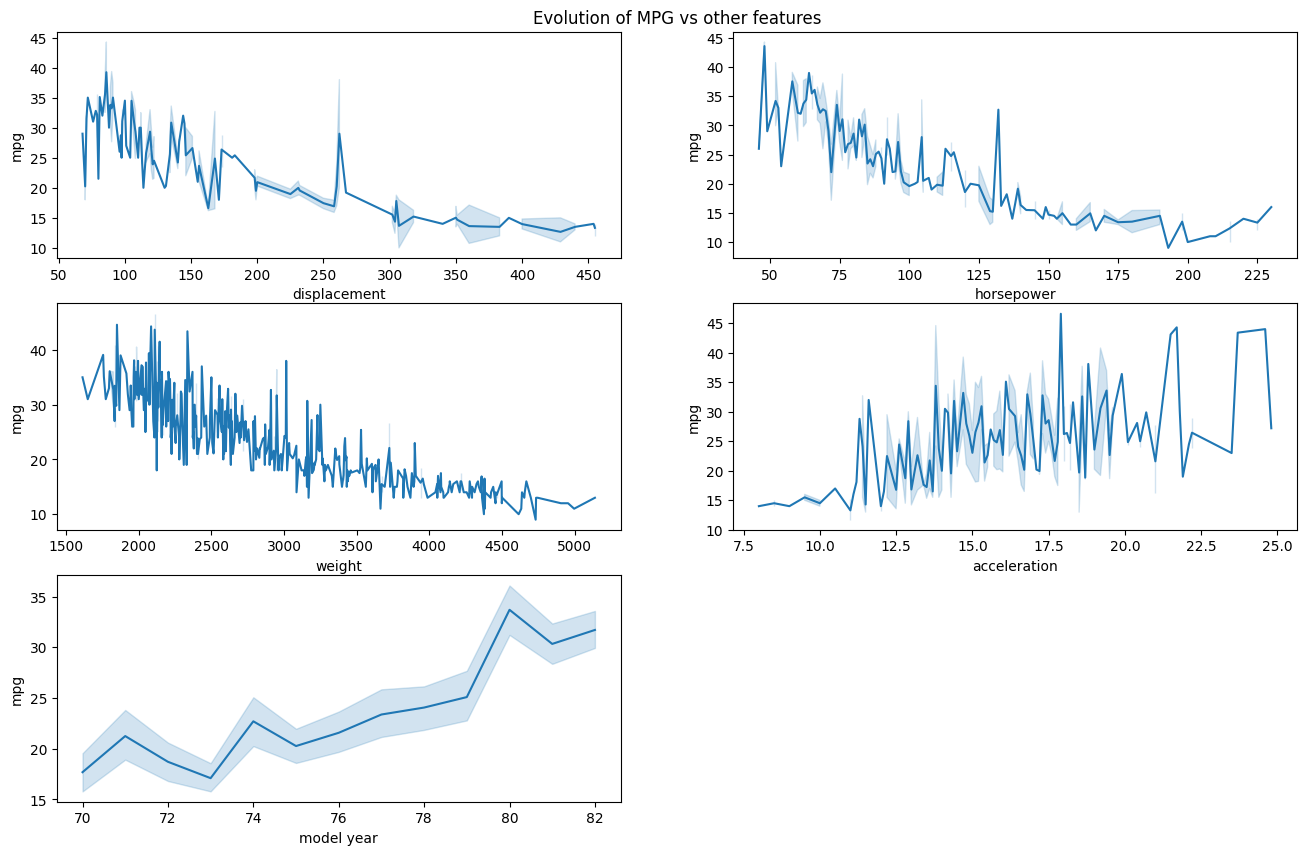

In [331]:
plt.figure(figsize=(16, 10))
plt.title("Evolution of MPG vs other features")
plt.axis('off')
for i, column in enumerate(data.columns.drop(['car name', 'mpg', 'origin', 'cylinders'])):
    plt.subplot(3, 2, i+1)
    sns.lineplot(x=column, y='mpg', data=data,
                 legend=False, palette='Set2')
plt.plot()

These line chart support the correlation matrix :
 * Recent cars are more and more full efficient.
 * Heavy and powerfull cars are less full efficient than light and less powerfull car.

In particular, we can see that mpg seems to have a **linear relation** with each other numeric feature.

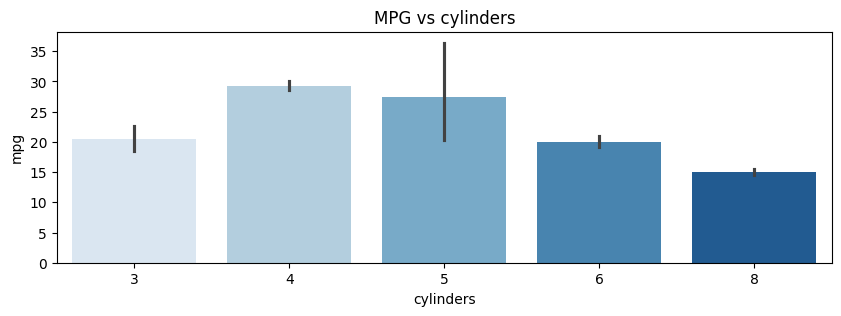

In [332]:
plt.figure(figsize=(10,3))
sns.barplot(data=data, x='cylinders', y='mpg', palette='Blues')
plt.title("MPG vs cylinders")
plt.show()

Most full efficient cars have 4 `cylinders`.

### Origin vs other features

[]

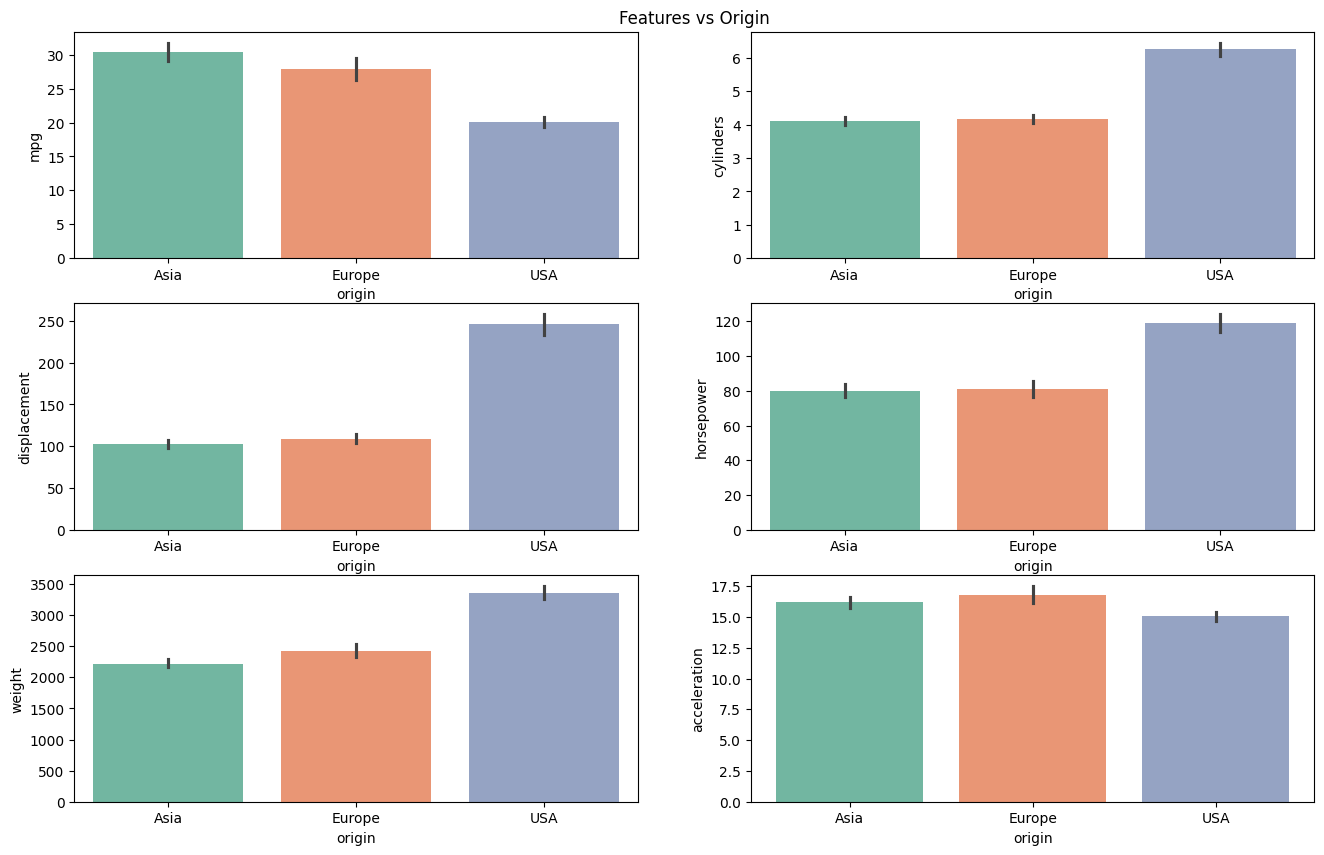

In [333]:
plt.figure(figsize=(16, 10))
plt.title("Features vs Origin")
plt.axis('off')
for i, column in enumerate(data.columns.drop(['car name', 'origin', 'model year'])):
    plt.subplot(3, 2, i+1)
    sns.barplot(data=data, x='origin', y=column, palette='Set2')

plt.plot()

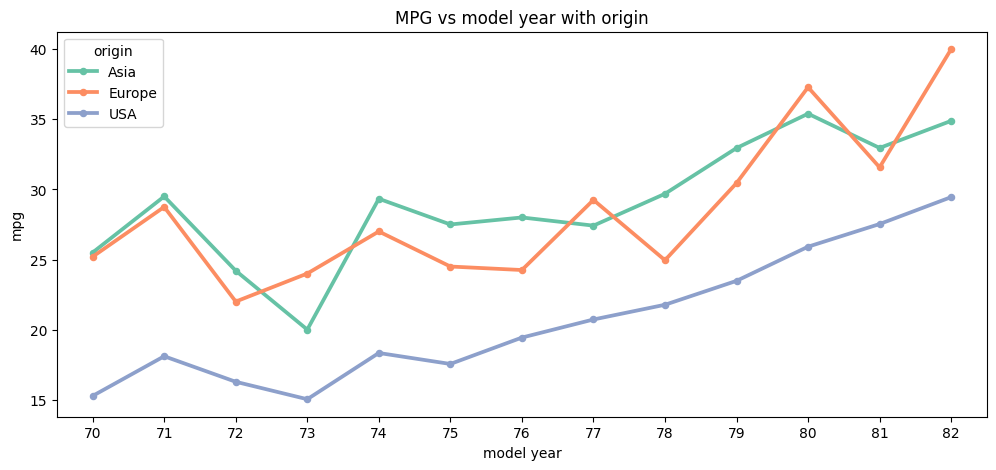

In [334]:
plt.figure(figsize=(12,5))
plt.title('MPG vs model year with origin')
sns.pointplot(data=data, x='model year', y='mpg', hue='origin',
              ci=None, markers='.', palette='Set2')
plt.show()

 - Cars from the **USA** have bigger and more powerfull engines so they are less full efficient (low `mpg`).
 - Cars from **Asia** and **Europe** are lighter and have smaller engines and are more full efficient (high `mpg`).

# Data Science & Machine Learning Training

In order to train a model on our dataset, we first need to make small adjustment and prepare the data.

## Preparing dataset to train a model

### One Hot encoding of categorical feature

In [335]:
data_num = data.drop(['car name'], axis=1) # remove non numeric features
data_num = pd.get_dummies(data=data_num, columns=['origin']) # One Hot Encoding

# Convert Booleans to Integers
data_num['origin_Asia'] = data_num['origin_Asia'].astype(int)
data_num['origin_Europe'] = data_num['origin_Europe'].astype(int)
data_num['origin_USA'] = data_num['origin_USA'].astype(int) 
data_num.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin_Asia,origin_Europe,origin_USA
0,18.0,8,307.0,130.0,3504,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449,10.5,70,0,0,1


### Split between train and test

In [336]:
X = data_num.drop(columns=['mpg'])
y = data_num['mpg']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Model Pipeline

As we discovered linear relations between features, we will use a simple LinearRegression model, after scaling the data.

In [338]:
pipeline = Pipeline([
    ('scaler', StandardScaler()), # scale data with (x - mean) / sd
    ('regression', RandomForestRegressor()) # Linear Regression
])

## Model Training

In [339]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regression', RandomForestRegressor())])

## Model Predictions & Testing

In [342]:
y_pred = pipeline.predict(X_test)

In [343]:
rmse = root_mean_squared_error(y_test, y_pred)
print(f'Root Mean Squared Error of Prediction : {rmse:.2f}')
print(f'Relative Error : {rmse/np.mean(data['mpg'])*100:.2f} %')

Root Mean Squared Error of Prediction : 2.31
Relative Error : 9.82 %


Predicted values are, in general, 2.31 away from real values.  
As `mpg` as a range of [10-50], a 2.31 error represent a 10 % distance with real values.



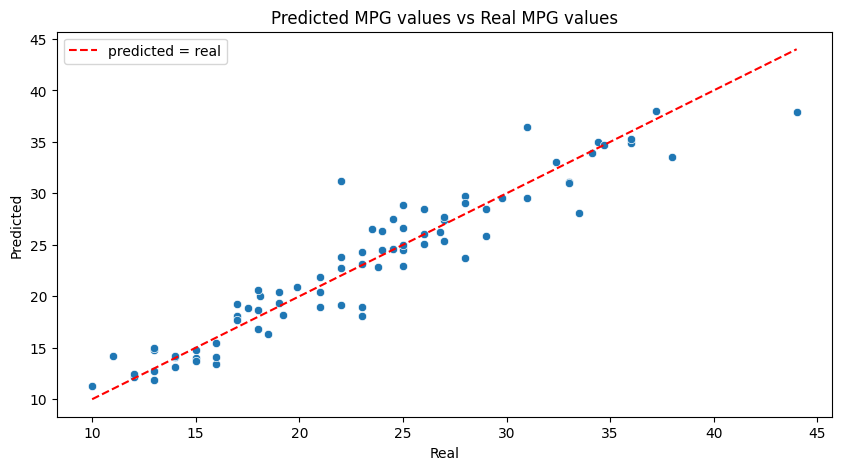

In [357]:
plt.figure(figsize=(10,5))
sns.scatterplot(x=y_test, y=y_pred, palette='Set2')
plt.xlabel('Real')
plt.ylabel('Predicted')
# adding y = x curve
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='predicted = real')

plt.title('Predicted MPG values vs Real MPG values')
plt.legend()
plt.show()

We can see that predicted values are really close to real values and equally distributed between *over* and *under* the $y=x$ curve. That means that our model do not tend to over-estimate nor under-estimate the target feature.

*note in this study, we will not try to increase the precision of our model as the goal is more to test the deployment using an API*

## Save model

In [360]:
joblib.dump(pipeline, 'model.pkl')

['model.pkl']